In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import scipy
import scipy.stats
import h5py
import os

#from cca.kron_pca import form_lag_matrix, toeplitzify
from cca.cov_util import calc_cross_cov_mats_from_data
from cca.synth_data import gen_lorenz_data, random_basis, median_subspace
from cca import ComplexityComponentsAnalysis, style

RESULTS_FILENAME = "lorenz_fig_data/lorenz_results.hdf5"

In [202]:
#Set this to False for safety
delete_old_file = False

#Set parameters
T = 4
N = 30
noise_dim = 7
snr_vals = np.logspace(-2, 2, 20)

#Save params
if delete_old_file:
    try:
        os.remove(RESULTS_FILENAME)
    except OSError:
        pass
f = h5py.File(RESULTS_FILENAME, "w-")
f.attrs["T"] = T
f.attrs["N"] = N
f.attrs["noise_dim"] = noise_dim
f.attrs["snr_vals"] = snr_vals

#Generate Lorenz dynamics
num_samples = 10000
X_dynamics = gen_lorenz_data(num_samples)
dynamics_var = np.max(scipy.linalg.eigvalsh(np.cov(X_dynamics.T)))

#Save dynamics
f.create_dataset("X_dynamics", data=X_dynamics)
f.attrs["dynamics_var"] = dynamics_var

#Generate dynamics embedding matrix (will remain fixed)
np.random.seed(42)
V_dynamics = random_basis(N, 3)
X = np.dot(X_dynamics, V_dynamics.T)

#Generate a subspace with median principal angles w.r.t. dynamics subspace
V_noise = median_subspace(N, noise_dim, num_samples=5000, V_0=V_dynamics)
#... and extend V_noise to a basis for R^N
V_noise_comp = scipy.linalg.orth(np.eye(N) - np.dot(V_noise, V_noise.T))
V_noise = np.concatenate((V_noise, V_noise_comp), axis=1)

#Save embeded dynamics and embedding matrices
f.create_dataset("X", data=X)
f.attrs["V_dynamics"] = V_dynamics
f.attrs["V_noise"] = V_noise

#To-save: noisy data, reconstructed PCA, reconstructed DCA
X_noisy_dset = f.create_dataset("X_noisy", (len(snr_vals), num_samples, N))
X_pca_trans_dset = f.create_dataset("X_pca_trans", (len(snr_vals), num_samples, 3))
X_dca_trans_dset = f.create_dataset("X_dca_trans", (len(snr_vals), num_samples, 3))

#Loop over SNR vals
for snr_idx in range(len(snr_vals)):
    snr = snr_vals[snr_idx]
    print("snr =", snr)
    noise_var = dynamics_var/snr
    
    #Generate noise covariacne
    noise_cov = gen_noise_cov(N, noise_dim, noise_var, V_noise=V_noise)
    
    #Generate noisy data
    np.random.seed(100)
    X_noisy = X + np.random.multivariate_normal(mean=np.zeros(N), cov=noise_cov, size=num_samples)
    X_noisy = X_noisy - X_noisy.mean(axis=0)

    #Save noisy data
    X_noisy_dset[snr_idx] = X_noisy

    #Compute PSD+Toeplitz spatiotemporal covariance
    cross_cov_mats = calc_cross_cov_mats_from_data(X_noisy, T)

    #Run DCA
    opt = ComplexityComponentsAnalysis(init="random_ortho")
    opt.cross_covs = cross_cov_mats
    opt.fit_projection(d=3, n_init=10)
    V_dca = opt.coef_

    #Run PCA
    V_pca = scipy.linalg.eigh(np.cov(X_noisy.T))[1][:, ::-1][:, :3]

    #Project data onto DCA and PCA bases
    X_dca = np.dot(X_noisy, V_dca)
    X_pca = np.dot(X_noisy, V_pca)

    #Linearly trasnform projected data to be close to original Lorenz attractor
    beta_pca = np.linalg.lstsq(X_pca, X_dynamics, rcond=None)[0]
    beta_dca = np.linalg.lstsq(X_dca, X_dynamics, rcond=None)[0]
    X_pca_trans = np.dot(X_pca, beta_pca)
    X_dca_trans = np.dot(X_dca, beta_dca)

    #Save transformed projections
    X_pca_trans_dset[snr_idx] = X_pca_trans
    X_dca_trans_dset[snr_idx] = X_dca_trans

snr = 0.01
snr = 0.016237767391887217
snr = 0.026366508987303583
snr = 0.04281332398719394
snr = 0.06951927961775606
snr = 0.11288378916846889
snr = 0.18329807108324356
snr = 0.29763514416313175
snr = 0.4832930238571752
snr = 0.7847599703514611
snr = 1.2742749857031335
snr = 2.06913808111479
snr = 3.359818286283781
snr = 5.455594781168514
snr = 8.858667904100823
snr = 14.38449888287663
snr = 23.357214690901213
snr = 37.92690190732246
snr = 61.584821106602604
snr = 100.0


In [2]:
def lorenz_fig_axes(fig_width=12, left_ax_width=0.1, left_ax_wpad=0.05, wpad_edge=0.05, wpad_mid=0.05, hpad_bottom=0.1, hpad_top=0.025, hpad_mid=0.075):
    sq_width = (1 - 2*wpad_edge - 3*wpad_mid - left_ax_width - left_ax_wpad)/4
    sq_height = (1 - hpad_top - hpad_bottom - hpad_mid)/2
    fig_height = sq_width*fig_width/sq_height
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    left_ax_height = left_ax_width*fig_width / fig_height
    left_box_height = 1. - hpad_top - hpad_bottom
    left_ax_hpad_edge = 0.0*left_box_height
    left_ax_hpad_mid = (1. - hpad_top - hpad_bottom - 2*left_ax_hpad_edge - 3*left_ax_height)/2
    left_ax_3 = fig.add_axes((wpad_edge, hpad_bottom + left_ax_hpad_edge, left_ax_width, left_ax_height))
    left_ax_2 = fig.add_axes((wpad_edge, hpad_bottom + left_ax_hpad_edge + left_ax_height + left_ax_hpad_mid,
                              left_ax_width, left_ax_height))
    left_ax_1 = fig.add_axes((wpad_edge, hpad_bottom + left_ax_hpad_edge + 2*left_ax_height + 2*left_ax_hpad_mid,
                              left_ax_width, left_ax_height))
    
    #Add top row
    #4 squares
    top_row_y = hpad_bottom + sq_height + hpad_mid
    
    #First one (Lorenz attractor plot) should be squished vertically
    smush_amt = 0.2*sq_height
    ax1 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad,
                        top_row_y + smush_amt, sq_width, sq_height - 2*smush_amt), projection='3d')
    
    #2 more simple squares in top row
    ax2 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + sq_width + wpad_mid,
                        top_row_y, sq_width, sq_height))
    ax3 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + 2*sq_width + 2*wpad_mid,
                        top_row_y, sq_width, sq_height))
    
    #Last square in top row has 2 pannels 
    upper_right_pad_top = 0.1*sq_height
    upper_right_pad_bottom = 0.1*sq_height
    upper_right_hpad = 0.2*sq_height
    upper_right_ax_height = (sq_height - upper_right_hpad - upper_right_pad_top - upper_right_pad_bottom)/2
    ax5 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + 3*sq_width + 3*wpad_mid,
                        top_row_y + upper_right_pad_bottom,
                        sq_width, upper_right_ax_height))
    ax4 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + 3*sq_width + 3*wpad_mid,
                        top_row_y + upper_right_pad_bottom + upper_right_ax_height + upper_right_hpad,
                        sq_width, upper_right_ax_height))
        
    #Bottom row
    #Special Lorenz plots on the left
    #First, do boring square on upper right
    ax12 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + 3*sq_width + 3*wpad_mid,
                         hpad_bottom, sq_width, sq_height))
    
    #Then, add a box with 6 subplots for Lorenz displays
    lorenz_box_width = 1. - 2*wpad_edge - wpad_mid - sq_width - left_ax_width - left_ax_wpad
    lorenz_box_height = sq_height
    
    lorenz_pad_left = 0.15*lorenz_box_width
    lorenz_pad_right = 0.05*lorenz_box_width
    lorenz_wspace = 0.05*lorenz_box_width
    
    lorenz_pad_top = 0.15*lorenz_box_height
    lorenz_pad_bottom = 0.0*lorenz_box_height
    lorenz_hspace = 0.05*lorenz_box_height
    
    lorenz_ax_width = (lorenz_box_width - lorenz_pad_left - lorenz_pad_right - 2*lorenz_wspace)/3
    lorenz_ax_height = (lorenz_box_height - lorenz_pad_bottom - lorenz_pad_top - lorenz_hspace)/2
    
    ax7 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + lorenz_pad_left,
                        hpad_bottom + lorenz_pad_bottom,
                        lorenz_ax_width, lorenz_ax_height), projection='3d')
    ax6 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + lorenz_pad_left,
                        hpad_bottom + lorenz_pad_bottom + lorenz_ax_height + lorenz_hspace,
                        lorenz_ax_width, lorenz_ax_height), projection='3d')
    
    ax9 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + lorenz_pad_left + lorenz_wspace + lorenz_ax_width,
                        hpad_bottom + lorenz_pad_bottom,
                        lorenz_ax_width, lorenz_ax_height), projection='3d')
    ax8 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + lorenz_pad_left + lorenz_wspace + lorenz_ax_width,
                        hpad_bottom + lorenz_pad_bottom + lorenz_ax_height + lorenz_hspace,
                        lorenz_ax_width, lorenz_ax_height), projection='3d')
    
    ax11 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + lorenz_pad_left + 2*lorenz_wspace + 2*lorenz_ax_width,
                         hpad_bottom + lorenz_pad_bottom,
                         lorenz_ax_width, lorenz_ax_height), projection='3d')
    ax10 = fig.add_axes((wpad_edge + left_ax_width + left_ax_wpad + lorenz_pad_left + 2*lorenz_wspace + 2*lorenz_ax_width,
                         hpad_bottom + lorenz_pad_bottom + lorenz_ax_height + lorenz_hspace,
                         lorenz_ax_width, lorenz_ax_height), projection='3d')
    
    dca_txt_x = wpad_edge + left_ax_width + left_ax_wpad + lorenz_pad_left/2
    dca_txt_y = hpad_bottom + lorenz_pad_bottom + lorenz_ax_height + lorenz_hspace + lorenz_ax_height/2
    pca_txt_x = dca_txt_x
    pca_txt_y = hpad_bottom + lorenz_pad_bottom + lorenz_ax_height/2
    
    #Add letter labels
    fig.text(wpad_edge, 1 - hpad_top, "A",
             va="bottom", ha="center", color="black", **style.panel_letter_fontstyle)
    fig.text(wpad_edge + left_ax_width + left_ax_wpad, 1 - hpad_top, "B",
             va="bottom", ha="center", color="black", **style.panel_letter_fontstyle)
    fig.text(wpad_edge + left_ax_width + left_ax_wpad + sq_width + wpad_mid, 1 - hpad_top, "C",
             va="bottom", ha="center", color="black", **style.panel_letter_fontstyle)
    fig.text(wpad_edge + left_ax_width + left_ax_wpad + 2*sq_width + 2*wpad_mid, 1 - hpad_top, "D",
             va="bottom", ha="center", color="black", **style.panel_letter_fontstyle)
    fig.text(wpad_edge + left_ax_width + left_ax_wpad + 3*sq_width + 3*wpad_mid, 1 - hpad_top, "E",
             va="bottom", ha="center", color="black", **style.panel_letter_fontstyle)
    fig.text(wpad_edge + left_ax_width + left_ax_wpad + 0.035, hpad_bottom + sq_height, "F",
             va="bottom", ha="center", color="black", **style.panel_letter_fontstyle)
    fig.text(wpad_edge + left_ax_width + left_ax_wpad + 3*sq_width + 3*wpad_mid, hpad_bottom + sq_height, "G",
             va="bottom", ha="center", color="black", **style.panel_letter_fontstyle)
    
    """
    fig.text(wpad_edge, hpad_bottom + sq_height, "E",
             va="bottom", ha="right", color="black", **style.panel_letter_fontstyle)
    fig.text(wpad_edge + 3*sq_width + 3*wpad_mid, hpad_bottom + sq_height, "F",
             va="bottom", ha="right", color="black", **style.panel_letter_fontstyle)
    """
    
    
    axes = [left_ax_1, left_ax_2, left_ax_3, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
    txt_cords = [(dca_txt_x, dca_txt_y), (pca_txt_x, pca_txt_y)]
    
    return axes, txt_cords



In [3]:
def plot_3d(X, color="black", linewidth=2, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    ax.plot(X[:, 0], X[:, 1], X[:, 2], c=color, linewidth=linewidth)

def plot_lorenz_3d(ax, X_dynamics, linewidth):
    ax_label_fontsize = style.axis_label_fontsize
    plot_3d(X_dynamics, ax=ax1, linewidth=linewidth)
    ax.xaxis.set_pane_color((1,1,1,0))
    ax.yaxis.set_pane_color((1,1,1,0))
    ax.zaxis.set_pane_color((1,1,1,0))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel("$x$", labelpad=-15, fontsize=ax_label_fontsize)
    ax.set_ylabel("$y$", labelpad=-15, fontsize=ax_label_fontsize)
    ax.set_zlabel("$z$", labelpad=-18, fontsize=ax_label_fontsize)
    ax.dist = 9
    
def plot_traces(ax, X, N_to_show, linewidth):
    y_spacing = 1.5 #spacing between adjacent traces on the y-axis (in data units)
    y_jump = 3 #empty y-space for elipsis
    #plot traces
    max_y = y_spacing*(N_to_show - 1) + y_jump
    offset_vals = [max_y - y_spacing*i for i in range(N_to_show)] + [0]
    t = np.arange(len(X))*0.025
    for i in range(N_to_show):
        ax.plot(t, X[:len(t), i] + offset_vals[i], c="black", linewidth=linewidth)
    ax.plot(t, X[:len(t), N_to_show], c="black", linewidth=linewidth)
    #configure the axis
    ax.set_xlim(np.min(t), np.max(t))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks(offset_vals)
    ax.set_yticklabels(list(np.arange(N_to_show)+1) + [X.shape[1]], fontsize=style.ticklabel_fontsize)
    ax.text(np.mean(t), y_jump*0.55,
            "···", rotation=90, fontsize=10, color="black",
            horizontalalignment="center", verticalalignment="center",
            fontweight="normal", fontname="Georgia")
    
def plot_dca_demo(ax_top, ax_bottom, X_random_trans, X_dca_trans, past_color, future_color, linewidth):
    #plot traces
    y_spacing = 3
    max_y = 2*y_spacing
    offset_vals = [max_y - i*y_spacing for i in range(3)]
    t = np.arange(len(X_random_trans))
    for i in range(3):
        ax_top.plot(t, X_random_trans[:len(t), i] + offset_vals[i], c="black", linewidth=linewidth)
        ax_bottom.plot(t, X_dca_trans[:len(t), i] + offset_vals[i], c="black", linewidth=linewidth)
    #configure axes
    for ax in [ax_top, ax_bottom]:
        ax.set_yticks([])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_xlim(np.min(t), np.max(t))
        ax.set_ylim(-y_spacing*1.025, max_y+y_spacing*1.025)
    #plot the colored past/future boxes
    t_range = t[-1] - t[0]
    t_mid = np.mean(t)
    t_low = t_mid - t_range*0.3
    t_high = t_mid + t_range*0.3
    n_t = 50
    t_low_vals = np.linspace(t_low, t_mid, n_t)
    t_high_vals = np.linspace(t_mid, t_high, n_t)
    y_low = -1*y_spacing
    y_high = max_y + y_spacing
    for ax in [ax_top, ax_bottom]:
        ax.fill_between(t_low_vals, y_low, y_high, alpha=1.0, color=past_color, linewidth=0)
        ax.fill_between(t_high_vals, y_low, y_high, alpha=1.0, color=future_color, linewidth=0)
        ax.text((t_low+t_mid)/2, y_high*1.4, "$X_{\mathrm{past}}$", color="black",
                horizontalalignment='center', verticalalignment='top',
                fontsize=style.axis_label_fontsize*0.75)
        ax.text((t_mid+t_high)/2, y_high*1.4, "$X_{\mathrm{future}}$",  color="black",
                horizontalalignment='center', verticalalignment='top',
                fontsize=style.axis_label_fontsize*0.75)
    #Add T labels
    ax_bottom.text((t_low+t_mid)/2, -y_spacing*1.2, "$T$", color="black",
            horizontalalignment='center', verticalalignment='top',
             fontsize=style.axis_label_fontsize)
    ax_bottom.text((t_mid+t_high)/2, -y_spacing*1.2, "$T$", color="black",
            horizontalalignment='center', verticalalignment='top',
             fontsize=style.axis_label_fontsize)

    ax_top.set_ylabel("random", fontsize=style.axis_label_fontsize*0.8, labelpad=1)
    ax_bottom.set_ylabel("DCA", fontsize=style.axis_label_fontsize*0.8, labelpad=1)
    
    
def plot_r2(ax, snr_vals, r2_vals, dca_color, pca_color):
    ax.plot(snr_vals, r2_vals[:, 1], label="DCA", linewidth=1, marker=".", markersize=3, c=dca_color, zorder=10)
    ax.plot(snr_vals, r2_vals[:, 0], label="PCA", linewidth=1, marker=".", markersize=3, c=pca_color, zorder=11)
    ax.set_xscale("log")
    for snr in plt_snr_vals:
        ax.axvline(snr, ymin=-0.025, ymax=1, c="black", linestyle='--', linewidth=0.7, zorder=0)
    ax.set_xlabel("SNR", fontsize=style.axis_label_fontsize)
    ax.set_ylabel("$R^2$", fontsize=style.axis_label_fontsize, labelpad=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds(-0.025, 1)
    ax.set_ylim([-0.025, 1.025])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(["0.0", "0.5", "1.0"], size=style.ticklabel_fontsize)
    ax.set_xticks([0.1, 1, 10])
    ax.set_xticklabels(["$10^{-1}$", "$10^0$", "$10^1$"], size=style.ticklabel_fontsize)
    ax.set_zorder(10**5)
    
def plot_cov(ax, theta_deg=55, sig_var=1, noise_var=5, noise_sig_labels=True, sig_color="purple", noise_color="green", dca_color="black", pca_color="red"):
    theta = np.deg2rad(theta_deg)
    v_sig = np.array([1, 0])
    v_noise = np.array([np.cos(theta), np.sin(theta)])
    cov_sig = sig_var * np.outer(v_sig, v_sig)
    cov_noise = noise_var * np.outer(v_noise, v_noise)
    cov = cov_sig + cov_noise
    
    w, V = scipy.linalg.eigh(cov)
    w, V = w[::-1], V[:, ::-1]
    if V[0, 0] < 0:
        V *= -1
    theta_prime = np.abs(np.arccos(V[0, 0]))
    theta_prime = np.minimum(theta_prime, np.pi - theta_prime)
    
    elipse_color = "0.85"
    ellipse = Ellipse((0, 0),
                      facecolor="white",
                      edgecolor=elipse_color,
                      width=2 * np.sqrt(w[0]),
                      height=2 * np.sqrt(w[1]),
                      angle=np.rad2deg(theta_prime),
                      linewidth=1,
                      alpha=1.0, linestyle="-",
                      zorder=0)
    ax.add_patch(ellipse)
    w = 2.7
    ax.set_xlim([-w, w])
    ax.set_ylim([-w, w])

    np.random.seed(100)
    pts = np.random.multivariate_normal(mean=np.zeros(2), cov=cov/4, size=5000)
    #only keep 100
    pt_x, pt_y = pts[:, 0], pts[:, 1]
    w_lim = w - 0.1
    good_idx = (pt_x > -w_lim) * (pt_x < w_lim) * (pt_y > -w_lim) * (pt_y < w_lim)
    pts = pts[good_idx][:100]
    
    ax.scatter(pts[:, 0], pts[:, 1], c=elipse_color, s=0.5)
    
    width = 0.02
    ax.quiver(0, 0, np.sqrt(sig_var)*v_sig[0], np.sqrt(sig_var)*v_sig[1], angles='xy', scale_units='xy', scale = 1, color=sig_color, width=width)
    ax.quiver(0, 0, -np.sqrt(sig_var)*v_sig[0], -np.sqrt(sig_var)*v_sig[1], angles='xy', scale_units='xy', scale = 1, color=sig_color, width=width)
    ax.quiver(0, 0, np.sqrt(noise_var)*v_noise[0], np.sqrt(noise_var)*v_noise[1], angles='xy', scale_units='xy', scale = 1, color=noise_color, width=width)
    ax.quiver(0, 0, -np.sqrt(noise_var)*v_noise[0], -np.sqrt(noise_var)*v_noise[1], angles='xy', scale_units='xy', scale = 1, color=noise_color, width=width)
    
    uv_len = 2
    #pca
    ax.quiver(0, 0, uv_len*V[0,0], uv_len*V[1,0], angles='xy', scale_units='xy', scale=1, width=width, color=pca_color)
    #dca
    ax.quiver(0, 0, uv_len*np.sin(theta), -uv_len*np.cos(theta), angles='xy', scale_units='xy', scale=1, width=width, color=dca_color)

    labelsize = 6
    if noise_sig_labels:
        ax.text(np.sqrt(sig_var), 0,
                "dynamics", va="center", ha="left", fontsize=labelsize, color=sig_color)
        ax.text(np.sqrt(noise_var)*v_noise[0],
                np.sqrt(noise_var)*v_noise[1],
                "noise", rotation=0, rotation_mode="anchor",
                va="bottom", ha="center", fontsize=labelsize, color=noise_color)
    ax.text(uv_len*V[0,0], uv_len*V[1,0],
            "PC1", va="center", ha="left", fontsize=labelsize, color=pca_color)
    ax.text(uv_len*np.sin(theta), -uv_len*np.cos(theta),
            "DC1", va="center", ha="left", fontsize=labelsize, color=dca_color)
    ax.axis("off")




In [4]:
f = h5py.File(RESULTS_FILENAME, "r")
snr_vals = f.attrs["snr_vals"]
X = f["X"]
X_noisy_dset = f["X_noisy"]
X_pca_trans_dset = f["X_pca_trans"]
X_dca_trans_dset = f["X_dca_trans"]
X_dynamics = f["X_dynamics"]

r2_vals = np.zeros((len(snr_vals), 2))
for snr_idx in range(len(snr_vals)):
    X_pca_trans = X_pca_trans_dset[snr_idx]
    X_dca_trans = X_dca_trans_dset[snr_idx]
    r2_pca = 1 - np.sum((X_pca_trans - X_dynamics)**2)/np.sum((X_dynamics - np.mean(X_dynamics, axis=0))**2)
    r2_dca = 1 - np.sum((X_dca_trans - X_dynamics)**2)/np.sum((X_dynamics - np.mean(X_dynamics, axis=0))**2)
    r2_vals[snr_idx] = [r2_pca, r2_dca]

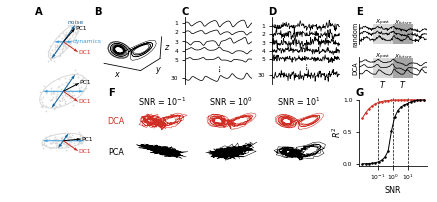

In [8]:
#Create axes
axes, txt_cords = lorenz_fig_axes(fig_width=5.5,
                                  wpad_edge=0.01, wpad_mid=0.05,
                                  left_ax_width=0.125, left_ax_wpad=0.025,
                                  hpad_bottom=0.132, hpad_top=0.06, hpad_mid=0.075)
left_ax_1, left_ax_2, left_ax_3, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = axes
linewidth_3d = 0.5
linewidth_2d = 0.75
linewidth_r2_plot = 1.0

#colors = ["#3E884C", "#523176", "#CF2F25"]
#colors = ["green", "purple", "#CF2F25"]
noise_color = "#1261A0"
sig_color = "#3B9CDD"
past_color = "0.85"
future_color = "0.65"
dca_color = "#CF2F25"
pca_color = "black"

T_to_show_2d = 150
T_to_show_3d = 500
X_display_idx = 8 #index of noisy X dataset to show (make sure to change if SNR spacing changes)

#ax1: Lorenz 3D Plot
plot_lorenz_3d(ax1, X_dynamics[:T_to_show_3d], linewidth_3d)

#ax2 and ax3: Plots of noiseless and noisy embeddings
N_to_show = 5 #number of channels to plot (also plot last one)
plot_traces(ax2, X[:T_to_show_2d], N_to_show, linewidth_2d)
#divide by a factor to make it look better
plot_traces(ax3, X_noisy_dset[X_display_idx, :T_to_show_2d]/1.8, N_to_show, linewidth_2d)

#ax4 and ax5: Plots of projections (DCA and random)
#get a random projection of X_noisy and transorm for Lorenz comparison
to_proj = X_noisy_dset[X_display_idx]
np.random.seed(42)
X_random = np.dot(to_proj, scipy.stats.ortho_group.rvs(to_proj.shape[1])[:, :3])
beta_random = np.linalg.lstsq(X_random, X_dynamics, rcond=None)[0]
X_random_trans = np.dot(X_random, beta_random)
plot_dca_demo(ax4, ax5, X_random_trans[:T_to_show_2d], X_dca_trans_dset[X_display_idx, :T_to_show_2d],
              past_color=past_color, future_color=future_color, linewidth=linewidth_2d)

#Plot Lorenz panels
dca_axes = [ax6, ax8, ax10]
pca_axes = [ax7, ax9, ax11]
plt_snr_vals = [0.1, 1.0, 10.0]
plt_snr_strs = ["$10^{-1}$", "$10^{0}$", "$10^{1}$"]
plt_idx = [np.argmin((snr_vals-snr)**2) for snr in plt_snr_vals]
for i in range(3):
    plot_3d(X_dca_trans_dset[plt_idx[i], :T_to_show_3d], ax=dca_axes[i], color=dca_color, linewidth=linewidth_3d)
    plot_3d(X_pca_trans_dset[plt_idx[i], :T_to_show_3d], ax=pca_axes[i], color=pca_color, linewidth=linewidth_3d)
    dca_axes[i].set_title("SNR = " + plt_snr_strs[i], pad=5, fontsize=style.axis_label_fontsize)
for ax in dca_axes + pca_axes:
    ax.set_axis_off()
    ax.dist = 7.5
plt.gcf().text(txt_cords[0][0], txt_cords[0][1], "DCA", va="center", ha="center", fontsize=style.axis_label_fontsize, color=dca_color)
plt.gcf().text(txt_cords[1][0], txt_cords[1][1], "PCA", va="center", ha="center", fontsize=style.axis_label_fontsize, color=pca_color)

#Finally, the R2 vs SNR plot
plot_r2(ax12, snr_vals, r2_vals, dca_color, pca_color)

#Left cov plots
left_ax_1.set_zorder(1000)
plot_cov(left_ax_1, sig_var=1, noise_var=5, noise_sig_labels=True, noise_color=noise_color, sig_color=sig_color, pca_color=pca_color, dca_color=dca_color)
plot_cov(left_ax_2, sig_var=5, noise_var=5, noise_sig_labels=False, noise_color=noise_color, sig_color=sig_color, pca_color=pca_color, dca_color=dca_color)
plot_cov(left_ax_3, sig_var=5, noise_var=1, noise_sig_labels=False, noise_color=noise_color, sig_color=sig_color, pca_color=pca_color, dca_color=dca_color)

plt.savefig("figures/lorenz_fig.pdf")

